# Preparing the dataset for a csv file


In [2]:
#Loading modules

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Features
from rdkit.Chem import Fragments as fr
from rdkit.Chem import rdMolDescriptors
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Lets import the dataset - the featurizer and splitter dont matter as we will be combining the datasets and
#designing our own featurizer
tasks, datasets, featurizer = dc.molnet.load_tox21(reload=False, featurizer="GraphConv", splitter="random")

[16:06:53] WARNING: not removing hydrogen atom without neighbors


In [4]:
train_dataset, valid_dataset, test_dataset = datasets

In [5]:
#Lets convert them to dataframes because deepchem is a piece of shit and it cant handle numpy arrays <-codeium generated this sentence

train_df = train_dataset.to_dataframe()
test_dataset = test_dataset.to_dataframe()
valid_dataset = valid_dataset.to_dataframe()

#This line concatenates all the dataframes meaning all the data is in one dataframe, we will resplit them later with SKLEARN
dataset = pd.concat([train_df, test_dataset, valid_dataset])


#print the columns
dataset.columns

Index(['X', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11',
       'y12', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
       'w11', 'w12', 'ids'],
      dtype='object')

In [6]:
#Lets first select only the useful information, ie the y values (toxicity)
#As well as the ids - ie the smiles strings
data = dataset[['ids', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12']]

# Lets add up all the y values into one 'toxicity measure
col_to_sum = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12']

#This adds a new column called 'tox' which is the sum of each row 
data['tox'] = data[col_to_sum].sum(axis=1)


In [7]:
#Lets add another row with a binary (1 or 0) that tells us if the compound is toxic against one or more of the assays or not
data['tox_bin'] = data['tox'].apply(lambda x: 1 if x>0 else 0)

In [8]:
#Get rid of the y columns - we dont need them anymore
data.drop(columns=['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'tox'], inplace=True)


In [9]:
import re

#Get all the possible functions within the fr(fragments) module and put them into a list
#This is called a list comprehension it says 'for each element in this list, do this'
#E.g for each name in the directory of the fr module, if the function is callable (i.e. it has a value) then append it to the list
function_names = [name for name in dir(fr) if callable(getattr(fr, name))]

#Remove the first 2 functions (they are not important for us)
function_names.pop(0)
function_names.pop(0)


'_LoadPatterns'

In [10]:
#Iterate through the rows in the dataframe
# For each row, create a molecule object from the smiles strings
# For each function in the list of functions, get the value for that function (in this case the total number of each functional group)
#Then add that value to the dataframe for that row with the column heading as the name of the function

for index, row in data.iterrows():
    mol = Chem.MolFromSmiles(row['ids']) # Create molecule object
    for function in function_names: # For each function in functions
        data.at[index, function] = getattr(fr, function)(mol) # Set the value in the dataframe at the molecule index and column name to the value of the function


[16:08:50] WARNING: not removing hydrogen atom without neighbors


In [11]:
#We have a list of functional groups, lets also get a binary value for if the molecule matches any of the tests below:
#PAINS, BRENK, NIH

from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import Descriptors as ds

params_pains = FilterCatalogParams()
params_pains.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains = FilterCatalog(params_pains)

params_brenk = FilterCatalogParams()
params_brenk.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk = FilterCatalog(params_brenk)

params_nih = FilterCatalogParams()
params_nih.AddCatalog(FilterCatalogParams.FilterCatalogs.NIH)
nih = FilterCatalog(params_nih)


SMILES_strings = data['ids'] # Get smiles strings
mol = [Chem.MolFromSmiles(formula) for formula in SMILES_strings] # Get a list of molecule objects

for row in data.index: # For each row
    molecule = mol[row] # Get the molecule
    data.loc[row, 'pain'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the PAINS filter?
    data.loc[row, 'brenk'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the BRENK filter?
    data.loc[row, 'nih'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the NIH filter?

[16:09:51] WARNING: not removing hydrogen atom without neighbors


In [12]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data, data['tox_bin'], test_size=0.2) # Split the entire dataset into train and test sets

X_train = X_train.drop(['tox_bin'], axis=1) # Drop the targets (toxicity indicator) from the X values of the training set
X_test = X_test.drop(['tox_bin'], axis=1) # Drop the targets (toxicity indicator) from the X values of the test set

X_train

,ids,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pain,brenk,nih
1828,COc1cccc(N(C)C(=S)Oc2ccc3c(c2)CCCC3)n1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc(S(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1972,NCCOCCN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3411,OC[C@H](O)[C@H](O)CO,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,SCc1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036,CNC(=O)N(C)c1nc2ccccc2s1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
897,CCCC(C)C(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,CC(C)CC(C)N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,CCCCCCCCCCCC(=O)N(CCO)CCO,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0


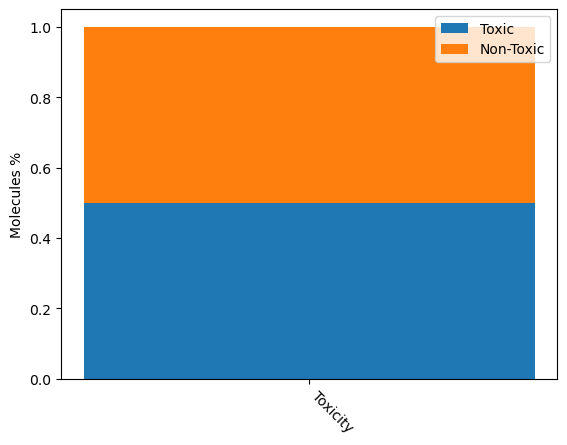

In [13]:
#Lets resample our data - there are a number of ways of doing this but the simplest is to jsut upsample the minority class
#Ie duplicate the samples

from sklearn.utils import resample

#First concatenate the training X and y into one dataframe
train_df = pd.concat([X_train, y_train], axis=1)

#Select the data in the majority and minority class
df_majority = train_df[train_df['tox_bin']==0]
df_minority = train_df[train_df['tox_bin']==1]

#Then resample the minority class - this will duplicate randomly the training data in the minority class to match the number of samples in the majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

#Then combine the majority and upsampled minority class
train_df = pd.concat([df_majority, df_minority_upsampled])

#Split them back into X and y values
y_train = train_df['tox_bin']
X_train = train_df.drop(['tox_bin'], axis=1)

#Then lets do what we did above to check it has worked!
percent_toxic = len(y_train[y_train == 1]) / len(y_train)
percent_non_toxic = 1 - percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

In [14]:
#Lets now split our test set into vaL and test sets
#Test will be used to test our model at the END of training
#Whereas validation will be used to test the model DURING training

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print('Shape of test set: ', X_test.shape)
print('Shape of validation set: ', X_val.shape)

Shape of test set:  (783, 89)
Shape of validation set:  (784, 89)


In [15]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
val = pd.concat([X_val, y_val], axis=1)

train.to_csv('train.csv')
test.to_csv('test.csv')
val.to_csv('val.csv')